# Analyse Exploratoire

In [1]:
# imports l'analyse exploratoire
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

# imports pour le machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

## Introduction

On va commencer par ignorer les divers warnings.

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Ce csv nous donne des informations sur le comportement habituels des clients d'une épicerie. On peut observer des choses comme les informations personnelles des clients, le revenu annuel, le nombre d'enfants, le nombre d'achat selon les différentes méthodes de ventes etc. 

On a donc un dataset qui semble à première contenir beaucoup d'information sur les clients ce qui nous permettra d'identifier différents clusters par la suite. 

## Traitement et Analyse de la donnée

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Le dataset possède 2240 observations et 28 variables.

### Premières observations

Ce dataset peut être séparé en 4 sets différent de données :

* Information client (id, date de naissance, education etc)
* Produits (Montant dépensé selon les différentes catégories de produits)
* Promotion (la participation aux différentes promotions)
* Canal de vente (l'endroit ou l'achat a été effectué; web, catalogue etc)

On peut également observer à l'aide du '.info()' plus haut qu'il manque des données dans la colonne income. 

La colonne Dt_Customer quant à elle a un datatype 'object' et non 'datetime'.

Il y a des variables catégorielles dans ce dataset qu'il faudra traiter tel quel ou les transformer en valeurs numériques.

In [6]:
df = df.dropna()
print("Nombre de lignes et de colonnes dans le dataset après suppression des valeurs manquantes : ", len(df))

Nombre de lignes et de colonnes dans le dataset après suppression des valeurs manquantes :  2216


### Traitement & Analyse

Nous commençons le traitement par la suppression des valeurs nulles. Pour traiter celles-ci nous allons les supprimer directement car elles ne représentent pas une énorme quantité de données. 

In [8]:
import pandas as pd

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)

dates = [i.date() for i in df["Dt_Customer"]]

print("Date du client le plus ancien : ", min(dates))
print("Date du client le plus récent : ", max(dates))

max_date = max(dates)
jours = [(max_date - date).days for date in dates]

df["Client depuis"] = jours


Date du client le plus ancien :  2012-07-30
Date du client le plus récent :  2014-06-29


Ici on a crée une feature à l'aide de la colonne 'Dt_Customer' qui nous permet de savoir depuis combien de jours un client a commencé ses achats au sein de l'épicerie.

In [9]:
print("Nombre de catégories dans la variable Marital_Status : ", df["Marital_Status"].value_counts())

Nombre de catégories dans la variable Marital_Status :  Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [10]:
print("Nombre de catégories dans la variable Education : ", df["Education"].value_counts())

Nombre de catégories dans la variable Education :  Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Ici on peut observer que dans la colonne Marital_Status on a notamment des valeurs qui n'ont pas de sens tel que YOLO ou encore Absurd. On a également des valeurs qui ont la même signification mais qui utilisent deux mots différents 'Alone' & 'Single'. 

Pour la colonne 'Education' il n'y a aucune valeur aberrante à première vue mais il s'agirait de potentiellement combiner certaines de ces valeurs afin de créer des catégories tels que 'Basic', '2nd cycle' & 'graduation' etc.

In [11]:
df["Âge"] = 2024 - df["Year_Birth"]

On récupère dans un premier temps l'âge des clients aujourd'hui afin d'avoir cette information si besoin.

In [12]:
df["Dépenses"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

Ici on va récupérer le montant dépensé par chaque clients peu importe la catégorie de produits.

In [13]:
df["Situation logement"] = df["Marital_Status"].replace({"Married": "Plusieurs", "Together": "Plusieurs", "Divorced": "Seul", "Widow": "Seul", "Single": "Seul", "Absurd": "Seul", "YOLO":"Seul"})

Ici on va se baser sur la colonne 'Marital_Status' afin de déterminer quels sont les clients qui vivent seuls et ceux qui vivent à plusieurs (1 vs 2)

In [14]:
df["Enfants"] = df["Kidhome"] + df["Teenhome"]

Ici on regroupe les deux types d'enfants 'kids' & 'teens' afin d'obtenir le nombre d'enfants total au sein du domicile.

In [15]:
# Replace "Seul" with 1 and "Plusieurs" with 2 in the "Situation logement" column
df["Situation logement"] = df["Situation logement"].replace({"Seul": 1, "Plusieurs": 2})

df["Situation logement"] = pd.to_numeric(df["Situation logement"], errors='coerce')

# Add the numerical values of "Situation logement" to the "Enfants" column
df["Taille foyer"] = df["Situation logement"] + df["Enfants"]

Ici on convertie la nouvelle variable 'Situation logemennt' en variable numérique afin de calculer le nombre de personnes dans le foyer en combinant avec la variable qui indique le nombre d'enfants.

In [16]:
df["Est Parent"] = np.where(df["Enfants"] > 0, 1, 0)

On crée une feature qui nous permettra d'isoler les parents dans le dataset. 

In [17]:
df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

Comme vu plus haut nous allons simplifier notre colonne Education afin de regrouper les niveaux d'études plus ou moins similaires.

In [18]:
df = df.rename(columns={"MntWines": "Vin", "MntFruits": "Fruits", "MntMeatProducts": "Viande", "MntFishProducts": "Poisson", "MntSweetProducts": "Sucré", "MntGoldProds": "Or"})

clean_up = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(clean_up, axis=1)

On drop les colonnes redondantes suite à la création de nos features ainsi que les colonnes qui ne seront pas utiles lors de notre prédiction de données. 

On change également le nom de quelques colonnes afin de faciliter la lecture du dataset.

In [19]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Vin,Fruits,Viande,Poisson,Sucré,Or,...,AcceptedCmp2,Complain,Response,Client depuis,Âge,Dépenses,Situation logement,Enfants,Taille foyer,Est Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2213.000000,2216.000000,2213.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.013538,0.009477,0.150271,353.521209,55.179603,607.075361,1.646182,0.947202,2.592408,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.478262,0.749062,0.906165,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,1.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,180.000000,47.000000,69.000000,1.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,355.500000,54.000000,396.500000,2.000000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,529.000000,65.000000,1048.000000,2.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,699.000000,131.000000,2525.000000,2.000000,3.000000,5.000000,1.000000


On voit qu'il y a des valeurs aberrantes notamment au niveau de 'income' avec un maximum à '666,666' ainsi que pour l'âge avec le client le plus âgé qui aurait 131 ans en 2024.

<Figure size 800x550 with 0 Axes>

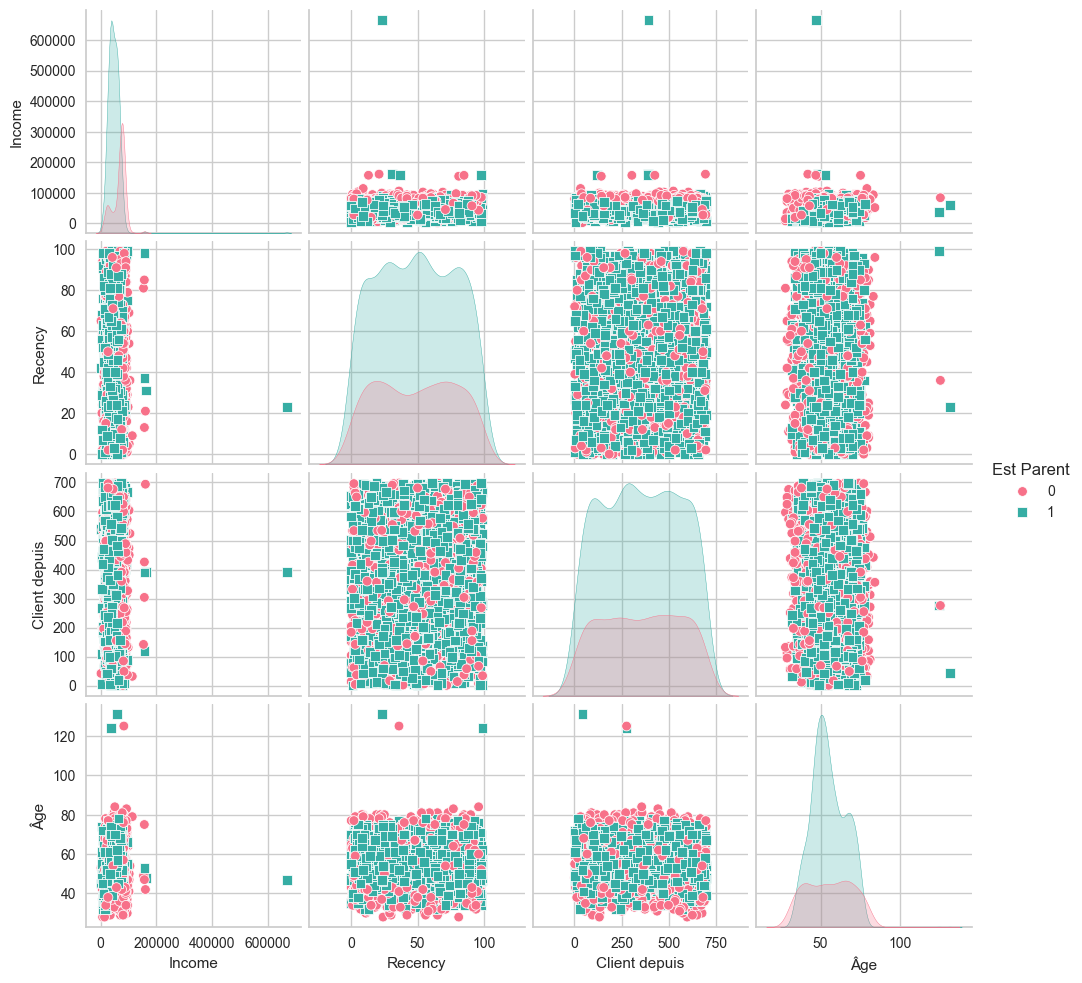

In [20]:
plot = ["Income", "Recency", "Client depuis", "Âge", "Est Parent"]
plt.figure()

sns.pairplot(df[plot], hue="Est Parent", palette="husl", markers=["o", "s"], diag_kind="kde")

plt.show()

On voit bel et bien qu'il y a des outliers pour les variables de l'âge et de l'income. On va supprimer les valeurs aberrantes de ces deux variables en mettant un maximum de 95 ans pour l'âge car le dataset date de quelques années et l'âge est calculé en fonction de notre année actuelle soit 2024. Pour ce qui est du revenu étant donné qu'on observe un seul outlier dans le graphique ci-dessus nous allons mettre un maximum de 650k afin de l'exclure.

In [21]:
df = df[(df["Âge"]<95)]
df = df[(df["Income"]<650000)]

print("Nombre de lignes et de colonnes dans le dataset après suppression des valeurs aberrantes : ", len(df))

Nombre de lignes et de colonnes dans le dataset après suppression des valeurs aberrantes :  2212


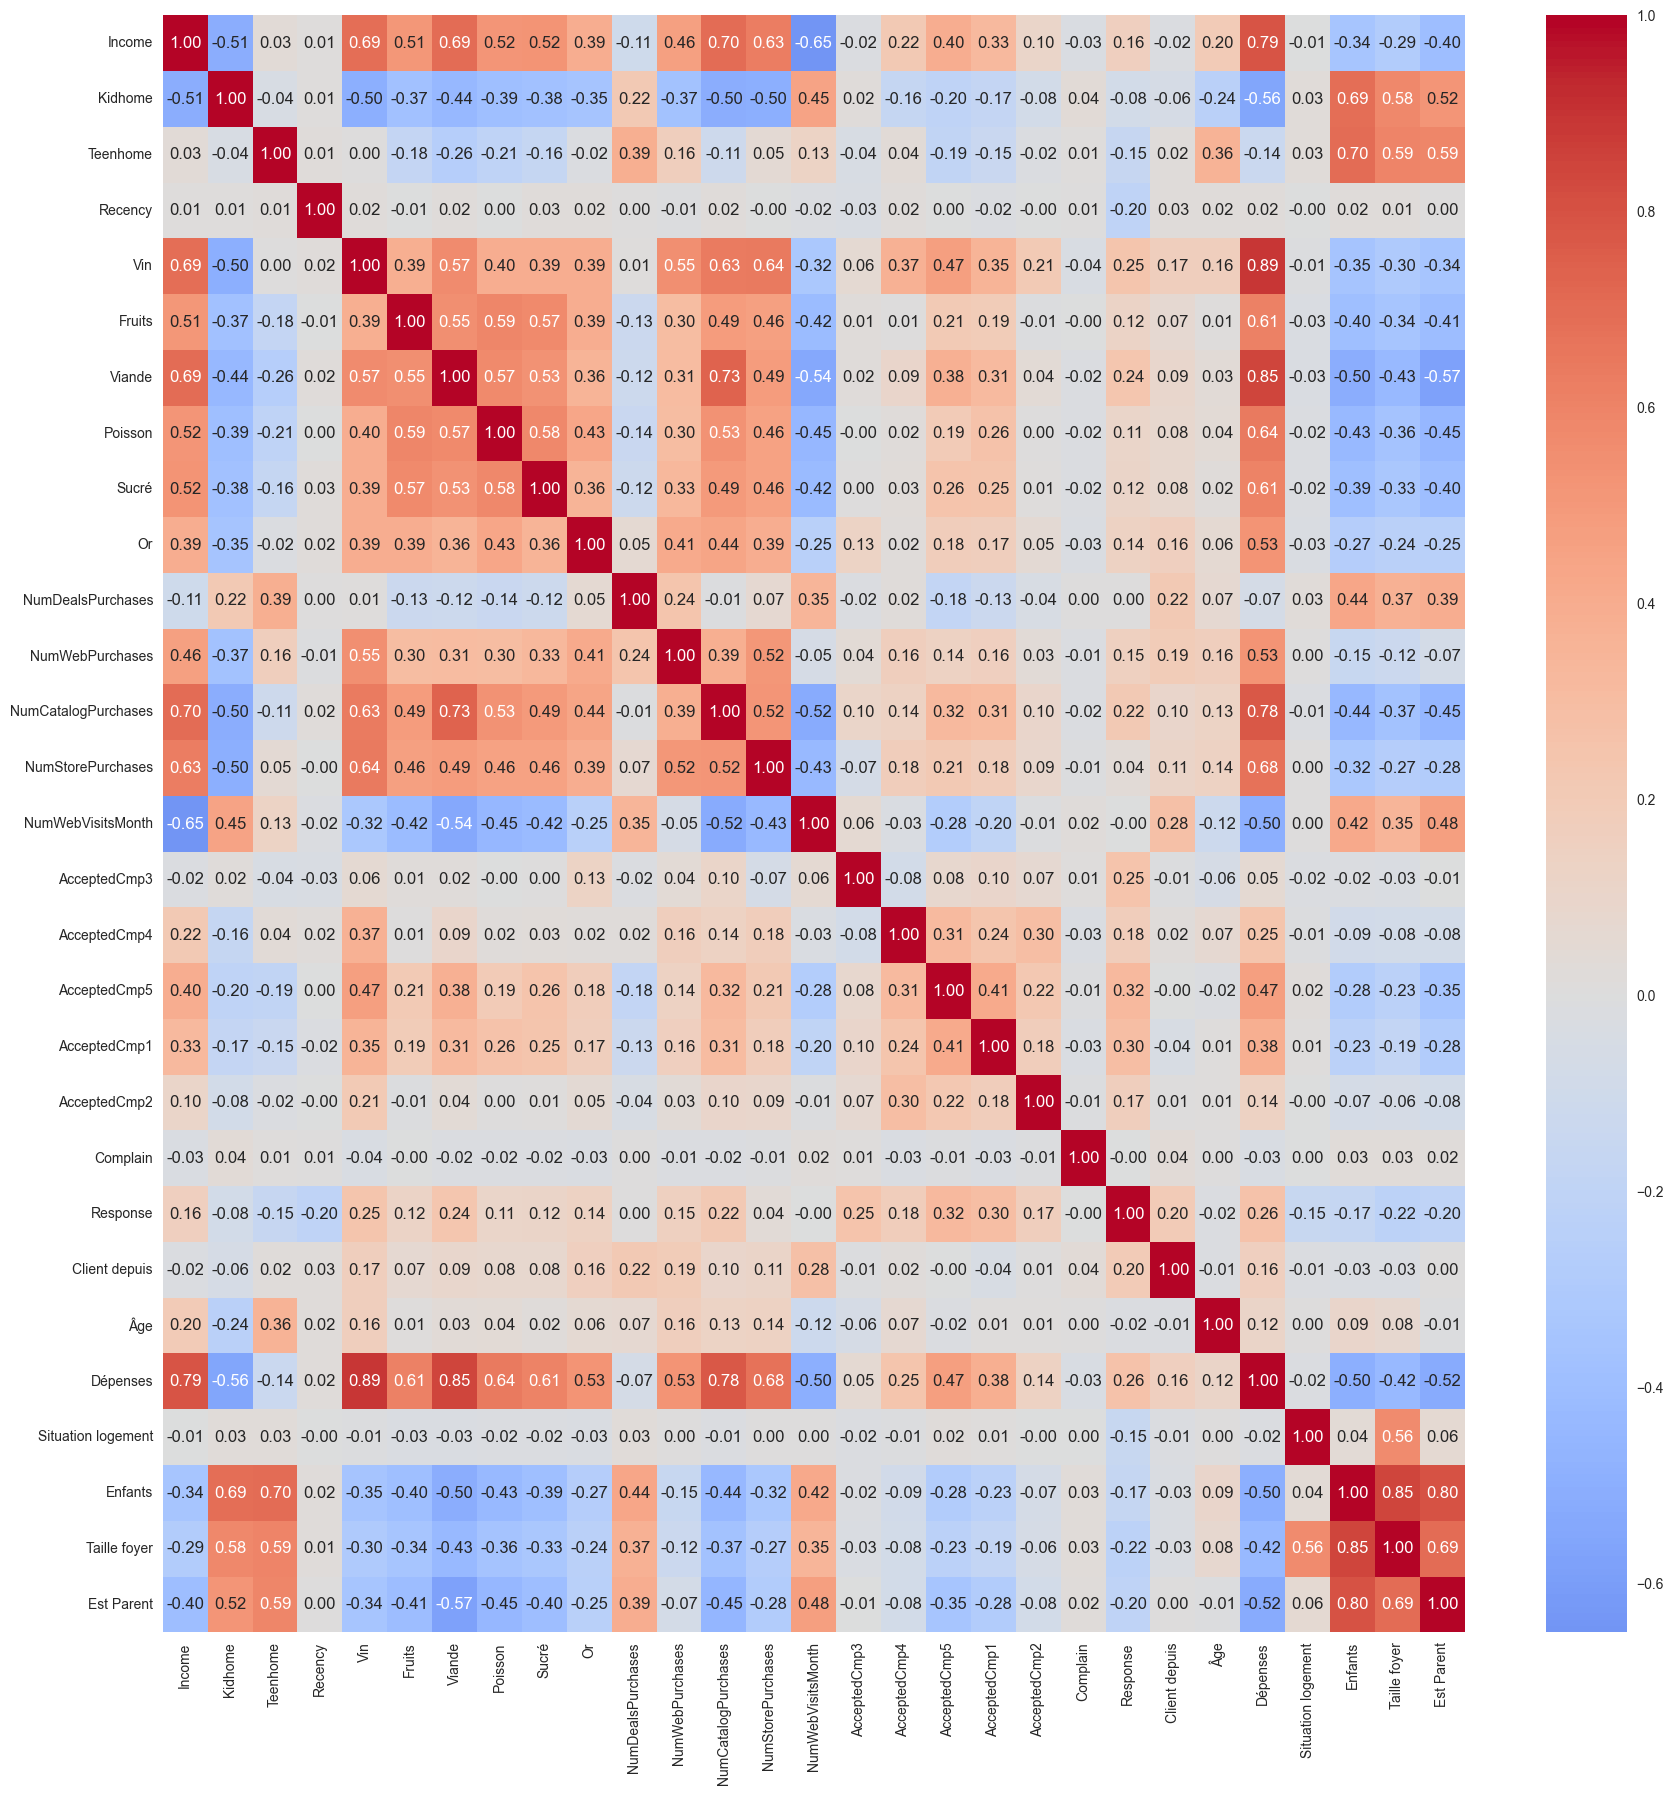

In [22]:
numeric_columns = df.select_dtypes(include=[int, float]).columns
correlation = df[numeric_columns].corr()

plt.figure(figsize=(21, 21))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.show()

On peut voir via cette matrice de corrélations que nous avons de nombreuses corrélations (positives & négatives) au dessus de 0.5 et en dessous de -0.5.

## Algorithmes

### K-Means

#### Data preprocessing

In [23]:

# Obtenir les variables catégorielles
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Variables catégorielles:", object_cols)

Variables catégorielles: ['Education']



On identifie les variables categorielles afin de les tranformer.

In [24]:
# Convertir les variables catégorielles en numériques
LE = LabelEncoder()
for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)

On les transforme en numerique.

In [25]:
ds = df.copy()

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns)


On effectue la mise à l'échelle des features afin de standardiser la plage des variables indépendantes et des features du dataset.

In [26]:

scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Vin,Fruits,Viande,Poisson,Sucré,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Client depuis,Âge,Dépenses,Situation logement,Enfants,Taille foyer,Est Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.352193,-1.264598,-1.757386,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.352193,1.404572,0.448960,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.739540,-1.264598,-0.654213,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.739540,0.069987,0.448960,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.739540,0.069987,0.448960,0.632456


### Réduction de dimension à l'aide de PCA

In [28]:
numeric_columns = df.select_dtypes(include=[int, float]).columns
df_numeric = df[numeric_columns]

imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = imputer.fit_transform(df_numeric)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_imputed)

pca = PCA(n_components=2)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["PC1","PC2"]))
PCA_ds.describe().T

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
x = PCA_ds['PC1']
y = PCA_ds['PC2']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(x, y, label='PCA')

ax.set_title('PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.legend()
plt.show()

Clustering

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10))
visualizer.fit(PCA_ds)
visualizer.show()

On peut voir ici que le nombre optimal de cluster est de 4.

In [ ]:

AC = AgglomerativeClustering(n_clusters=4)
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds['Cluster'] = yhat_AC
df['Cluster'] = yhat_AC

In [ ]:

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
ax.scatter(x, y, s=40, c=PCA_ds["Cluster"], cmap='viridis', alpha=0.5)
ax.set_title("The Plot Of The Clusters")
plt.show()

Ici on peut apercevoir nos 4 clusters et leur répartition.

### Evaluation du modèle

In [ ]:
pl = sns.countplot(x=PCA_ds["Cluster"], palette='viridis')
pl.set_title('Nombre de clients par cluster')
plt.show()

On peut observer la répartition des clients en fonction des differents clusters. On remarque que les cluster sont globalement bien distirbués.

In [ ]:

silhouette_score = metrics.silhouette_score(PCA_ds, PCA_ds["Cluster"])
print("Silhouette Score:", silhouette_score)


Nous avons un score de Silhouette de 0.52 via le KMeans.

In [ ]:
df.groupby('Cluster').describe().T

In [ ]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x="Dépenses", y="Income", data=df, hue="Cluster", palette='viridis')
plt.title("Dépenses vs Income par Cluster")
plt.show()

Ce graphique nous montre la répartition des différents clusters selon les revenues et dépenses.

On peut voir que :

- Cluster 0; dépenses élevés et revenu élevé  
- Cluster 1; dépenses faibles et revenu moyen  
- Cluster 2; dépenses très élevées et revenu élevé  
- Cluster 3; très faibles dépenses et revenu faible  

In [ ]:
plt.figure()
pl=sns.swarmplot(x="Cluster", y="Dépenses", data=df, palette='viridis')
pl.set_title('Dépenses par Cluster')
plt.show()

In [ ]:
plt.figure()
pl=sns.swarmplot(x="Cluster", y="Income", data=df, palette='viridis')
pl.set_title('Revenu par Cluster')
plt.show()

In [ ]:
# nb de promos cmp acceptées par cluster
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

plt.figure()
pl=sns.countplot(x="Cluster", hue="Total_Promos", data=df, palette='viridis')
pl.set_title('Nombre de promos acceptées par Cluster')
plt.show()

### Classification Ascendante Hiérarchique

### Réduction de dimension à l’aide de la sélection de feature et/ou l'analyse à facteurs multiples

Sélection des caractéristiques numériques

In [ ]:
# Select the numerics columns
numeric_columns = df.select_dtypes(include=[int, float]).columns
df_numeric = df[numeric_columns]
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = imputer.fit_transform(df_numeric)

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_imputed)

# Use ACP
pca = PCA(n_components=4)  
principal_components = pca.fit_transform(df_scaled)

# Create a dataframe with main components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['Est Parent'] = df['Est Parent'].values 

Visualisation des résultats de l'ACP

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Est Parent', palette='husl', data=df_pca)
plt.title('Visualisation des composantes principales')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

Explication des composantes principales

In [ ]:
pca_components = pd.DataFrame(pca.components_, columns=numeric_columns, index=['PC1', 'PC2', 'PC3', 'PC4'])
print(pca_components)

### Utilisation algo CAH

Tout d'abord je fais un échantillonnage des données afin d'alléger la charge de calcul.

In [ ]:
sample_size = 500
df_sample = df_pca.sample(n = sample_size, random_state = 42)

Je fais un test de différents nombres de clusters

In [ ]:
best_score = -1
best_n_components = 0
best_n_clusters = 0
best_clusters = None

J'applique le CAH sur l'échantillon

In [ ]:
for n_components in [2, 3, 5, 7]:
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df_scaled)
    df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    for n_clusters in range(2, 11):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(df_pca)
        score = silhouette_score(df_pca, labels)
        
        if score > best_score:
            best_score = score
            best_n_components = n_components
            best_n_clusters = n_clusters
            best_labels = labels

print(f'Best Silhouette Score: {best_score} with {best_n_components} components and {best_n_clusters} clusters')

J'applique le clustering avec le meilleur nombre de composantes principales et de clusters

In [ ]:
pca = PCA(n_components=best_n_components)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(best_n_components)])
df_pca['Cluster'] = best_labels

Je visualise les clusters

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='rainbow', data=df_pca)
plt.title('Clusters obtenus par CAH avec le meilleur nombre de composantes et de clusters')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

Je crée le dendrogramme pour la visualisation de la hiérarchie des clusters

In [ ]:
linked = linkage(df_pca.iloc[:, :best_n_components], 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogramme CAH')
plt.xlabel('Index des Points de Données')
plt.ylabel('Distance')
plt.show()

Evaluation des clusters avec le score de silhouette

In [ ]:
print(f'Best Silhouette Score: {best_score}')

### DBSCAN

In [ ]:
eps = 0.5  # Rayon du voisinage
min_samples = 5  # Nombre minimum de points dans un voisinage pour être un noyau

# Initialisation de DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit et prédiction des clusters
labels = dbscan.fit_predict(principal_components)

# Évaluation avec le score de silhouette
silhouette = silhouette_score(principal_components, labels)
print(f'Silhouette Score pour DBSCAN: {silhouette}')

## Conclusion